# User Guide

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import time

In [2]:
d1=pd.read_pickle("ReturnData/sgold.pkl")
d2=pd.read_pickle("ReturnData/cgold.pkl")

In [3]:
import CrossQuantilogram as cq

******


## Lower Level Functions

### 1. Descriptive Statistics

Use `DescriptiveStatistics(data,maxlag)` to calculate the corr between two series. It is in `.utils.py`
<br>
`maxlag` are the max lag for ADF test.

In [5]:
cq.DescriptiveStatistics(d1["day"],20)

{'mean': 6.987367579019611e-05,
 'median': 0.0,
 'min': -0.07843270189408003,
 'max': 0.04487175417717548,
 'std': 0.009584121721712784,
 'skew': -0.3670340493550927,
 'kurt': 5.455280842021169,
 'adfs': -47.20750948402644,
 'adfpv': 0.0}

`adfs` is the statistics of ADF test. `adfpv` is the P-value of rejecting $H_0$. Here we find the data is stationary.

### 2. Cross-Quantilogram

$$\rho_α(k)=\frac{E[\psi_{\alpha_1}(x_{1,t}-q_1(\alpha_1))\psi_{\alpha_2}(x_{2,t-k}-q_2(\alpha_2))]}{\sqrt{\psi_{\alpha_1}^2(x_{1,t}-q_1(\alpha_1))}\sqrt{\psi_{\alpha_2}^2(x_{2,t-k}-q_2(\alpha_2))}}$$

Use `CrossQuantilogram(x1,alpha1,x2,alpha2,k)`to calculate the corr between two series.<br>
It means the predictability from X2(t-k) to X1(t).

* Input: x1 series,
    * `x1`:array-like, series-1.
    * `alpha1`: float between (0,1), quantile of serie-1.
    * `x2`:array-like, serie-2.
    * `alpha2`: float between (0,1), quantile of serie-2.
    * `k`: non-negative integer, the serie-2's lag.
* Output:
    * A float number.

In [6]:
cq.CrossQuantilogram(d1["day"],0.1,d2["day"],0.1,1)

0.2971576227390181

x1 can be n-columns series. It will return an array.

In [7]:
cq.CrossQuantilogram(d1[["day","intraday","overnight"]],0.1,d2["day"],0.1,1)

array([0.29715762, 0.00258398, 0.34366925])

### 3. Stationary Bootstrap

Use Bootstrap() to generate bootstrapped sample. It is in `.stationarybootstrap.py`

* Input: 
    * `x1`: array-like, serie-1.
    * `x2`: array-like, serie-2. 
    * `lag`: integer, x2's lag.
    * `bslength`: integer, output length.
    * `bsd`: BSDistribution instance, the distribution for $L_i$.
    * `verbose`: boolean.
* Output:
    * A tuple including 2 bootstrapped series x1,x2

In [8]:
cq.Bootstrap(np.arange(100),np.arange(100,200),10,100,verbose=True)

Generating samples:259/100(100%)   


(array([84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 32, 33, 34, 35, 36, 37,
        38, 39, 40, 41, 42, 43, 44, 45, 46, 30, 31, 32, 33, 34, 35, 36, 19,
        20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36,
        37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
        54, 55, 56, 57, 58, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27,
        28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42]),
 array([174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 122, 123,
        124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136,
        120, 121, 122, 123, 124, 125, 126, 109, 110, 111, 112, 113, 114,
        115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127,
        128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140,
        141, 142, 143, 144, 145, 146, 147, 148, 106, 107, 108, 109, 110,
        111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123,
        124, 125, 126, 127, 128, 129, 1

We usually generate data with length same as sample.

In [9]:
cq.Bootstrap(d1["day"],d2["day"],20,d1.shape[0],verbose=True)

Generating samples:2211/2151(100%)   


(array([-0.0043024 ,  0.00537512,  0.00723369, ..., -0.00166466,
        -0.00594135,  0.0027894 ]),
 array([ 0.0089821 ,  0.00390444,  0.00450521, ...,  0.00190916,
        -0.00190916, -0.01120998]))

In [10]:
%timeit cq.Bootstrap(d1["intraday"],d2["day"],20,d1.shape[0],verbose=False)

555 µs ± 30 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


### 3. Hypothesis Tests

$H_0 : \rho_{\alpha}(1)=...=\rho_{\alpha}(k)=0$

$H_1 : \rho_\alpha(k)\neq0$ for some $k \in \{1,...,p\}$

Use `LjungBoxQ(cqlist,maxp,T)` or `BoxPierceQ(cqlist,maxp,T)` to calculate $Q$ statistics. Use stationary bootstrapped CQ and corresponding $Q$ as a asymptotic distribution to test. 1000 bootstrap repeats are enough.

****

## Higher Level Functions

Here's some frequently used higher-level API. They are contained in `.calculate.py`

### 1. Cross-Quantilogram with Bootstrap for lags

We can use `CQBS(data1,a1,data2,a2,k,cqcl=0.95,testf=LjungBoxQ,testcl=0.95,n=1000,verbose=True)` to calculate 
CQ at a certain quantile $(\alpha_1,\alpha_2)$ for different lags $\{k|k \in \mathbb{Z^+\}}$. It can be used for bar plotting.

* Input:
    * `data1`: array-like, serie-1.
    * `a1`: float between (0,1), quantile of serie-1.
    * `data2`: array-like, serie-2 (k lagged).
    * `a2`: float between (0,1), quantile of serie-2.
    * `k`: non-negative integer, the serie-2's max lag.
    * `cqcl`: optional float between (0,1), the level of confidence interval of CQ, 0.95 as default.
    * `testf`: optional function, a function calculating the test statistics Q, `qtests.LjungBoxQ` as default.
    * `testcl`: optional float between (0,1), the critical level of Q statistics, 0.95 as default. 
    * `n`: optional integer, the repeating time of bootstrap, 1000 as default.
    * `verbose`: optional boolean, if it will print the procedure.
* Output:
    * pandas.DataFrame containing k rows(k lags) and 5 cols("cq","cq_upper","cq_lower","q","qc")

In [11]:
t1=time.time()
res1=cq.CQBS(d1["day"],0.1,d2["day"],0.1,k=10,cqcl=0.95,testcl=0.95,n=1000,verbose=True)
print("time cost: {}s".format(time.time()-t1))
res1

Bootstraping CQ done      
time cost: 8.037155151367188s


,cq,cq_upper,cq_lower,q,qc
1,0.297158,0.074935,-0.043501,190.204037,7.940617
2,0.018037,0.071047,-0.022839,190.905140,13.055649
3,0.085177,0.101409,0.002481,206.547145,25.476031
4,0.028273,0.055380,-0.027664,208.271393,27.573408
5,0.002378,0.081284,-0.033358,208.283594,32.197744
6,0.054019,0.065663,-0.028690,214.583764,33.774020
7,0.028122,0.064309,-0.013234,216.292067,36.171499
8,0.012563,0.044190,-0.033069,216.633124,37.616707
9,0.007342,0.095949,0.007875,216.749654,46.662264
10,0.018743,0.075853,-0.006204,217.509499,52.046255


### 2. Cross-Quantilogram with Bootstrap for alphas

We can use `CQBS_alphas(data1,a1list,data2,a2list,k=1,cqcl=0.95,testf=LjungBoxQ,testcl=0.95,all=False,n=1000,verbose=True)` to calculate CQ at a certain lag $k$ for different quantile $\{(\alpha_1,\alpha_2)|\alpha_1,\alpha_2 \in (0,1)\}$. It will return a 2D list, which can be used for heatmap.

Return a 2D list of DataFrame(if all=True) or a 2D list of dict(if all=False). Shape:$[row(data2),col(data1)]$ <br>
It's slow beacuse of calling `CQBS()` for $len(a1list)×len(a2list)$ times.
* Input:
    * `data1`: array-like, serie-1.
    * `a1list`: array-like and between (0,1), quantiles of serie-1.
    * `data2`: array-like, serie-2 (k lagged).
    * `a2list`: array-like and between (0,1), quantiles of serie-2.
    * `k`: optional non-negative integer, the serie-2's max lag, 1 as default.
    * `cqcl`: optional float between (0,1), the level of confidence interval of CQ, 0.95 as default.
    * `testf`: optional function, a function calculating the test statistics Q, `qtests.LjungBoxQ` as default.
    * `testcl`: optional float between (0,1), the critical level of Q statistics, 0.95 as default.
    * `all`: optional boolean, True if you want to save all [1,k] results so the 2D list will contain DataFrame;         False if you want to save the last result (only for lag k) so the 2D list will contain dict, False as default.
    * `n`: optional integer, the repeating time of bootstrap, 1000 as default.
    * `verbose`: optional boolean, if it will print the procedure.
* Output:
    * 2D list, rows(1D) for data2, cols(2D) for data1, items are dicts or DataFrame(return of `CQBS`)


In [12]:
t1=time.time()
alist=[0.1,0.5,0.9]
res2=cq.CQBS_alphas(d1["day"],alist,d2["day"],alist,k=1,cqcl=0.95,testcl=0.95,all=False,n=1000,verbose=True)
print("time cost: {}s".format(time.time()-t1))
res2

Bootstraping CQ done      
time cost: 7.405273914337158s


array([[{'cq': 0.2971576227390181, 'cq_upper': 0.06976744186046516, 'cq_lower': -0.04909560723514211, 'q': 190.2040372406063, 'qc': 8.110606017187862},
        {'cq': 0.15007751937984495, 'cq_upper': 0.020155038759689922, 'cq_lower': -0.06604651162790699, 'q': 48.515137394996664, 'qc': 7.011681628837715},
        {'cq': 0.06976744186046513, 'cq_upper': -0.019761175192510572, 'cq_lower': -0.10816643263268941, 'q': 10.484593054699591, 'qc': 22.191948659326645}],
       [{'cq': 0.1937984496124031, 'cq_upper': 0.031072050092957795, 'cq_lower': -0.037286460111549354, 'q': 80.89963776774373, 'qc': 2.516350696585456},
        {'cq': 0.20651162790697675, 'cq_upper': 0.010232558139534883, 'cq_lower': -0.06325581395348837, 'q': 91.86181050805591, 'qc': 6.935674801162162},
        {'cq': 0.16899224806201552, 'cq_upper': -0.016984189253837184, 'cq_lower': -0.0883720930232558, 'q': 61.51479016438805, 'qc': 14.543813279333895}],
       [{'cq': 0.08010335917312664, 'cq_upper': 0.02278617006816904, 'c

### 3. Cross-Quantilogram with Bootstrap for time periods (Rolling)

We can use `CQBS_years(data1,a1,data2,a2,k=1,window=1,cqcl=0.95,testf=LjungBoxQ,testcl=0.95,all=False,n=1000,verbose=True)` to calculate rolling CQ at a certain $(\alpha_1,\alpha_2)$ and a certain lag $k$ for different years. It will return a list which can be used for rolling line plotting.

Return 1 DataFrame(if all=False) or a list of DataFrame(if all=True) at $lag∈[1,k]$.<br>
It's slow beacuse of calling `CQBS()` for $\#years$ times.
* Input:
    * `data1`: array-like, serie-1.
    * `a1`: float between (0,1), quantile of serie-1.
    * `data2`: array-like, serie-2 (k lagged).
    * `a2`: float between (0,1), quantile of serie-2.
    * `k`: optional non-negative integer, the serie-2's max lag, 1 as default.
    * `window`: optional positive integer, the rolling window (years), 1 as default.
    * `cqcl`: optional float between (0,1), the level of confidence interval of CQ, 0.95 as default.
    * `testf`: optional function, a function calculating the test statistics Q, `qtests.LjungBoxQ` as default.
    * `testcl`: optional float between (0,1), the critical level of Q statistics, 0.95 as default.
    * `all`: optional boolean, True if you want to save all [1,k] results so the list will contain k DataFrame, 
        False if you want to save the last result (only for lag k) so it will return 1 DataFrame, False as default.
    * `n`: optional integer, the repeating time of bootstrap, 1000 as default.
    * `verbose`: optional boolean, if it will print the procedure.
* Output:
    * pandas.DataFrame(return of CQ_lags) or a list of pandas.DataFrame(if all=True).


In [13]:
t1=time.time()
res3=cq.CQBS_years(d1["day"],0.1,d2["day"],0.1,k=1,window=1,cqcl=0.95,testcl=0.95,all=False,n=1000,verbose=True)
print("time cost: {}s".format(time.time()-t1))
res3

Bootstraping CQ done      
time cost: 5.075068473815918s


,cq,cq_upper,cq_lower,q,qc
2010,0.613713,0.089136,-0.104972,88.516201,1.867229
2011,0.582367,0.164733,-0.020882,81.061381,3.346624
2012,0.535747,0.025070,-0.114206,68.315708,3.104411
2013,0.130014,0.236123,-0.010352,3.938800,8.912714
2014,0.025974,0.084778,-0.113173,0.161925,3.074089
2015,-0.020882,0.025522,-0.113689,0.104220,3.089290
2016,0.071926,-0.067285,-0.113689,1.236488,3.089290
2017,0.072356,0.084778,-0.102204,1.256568,1.725063
2018,0.118329,0.125318,-0.111131,3.346624,3.346624
2019,-0.126761,0.154930,-0.126761,0.628039,0.628039


## Plotting Scripts

We provide 3 typical kinds of plotting for researches. You can find their codes in `.plot.py`

## 1. Bar plot with CQBS()

```Python
def bar_example(data1,data2,picname="",show=True):
    alist=[0.1,0.5,0.9]
    dataset=[CQBS(data1,alist[i],data2,alist[i],20,verbose=True) for i in range(3)]

    fig1,ax1=plt.subplots(2,3,figsize=(12,4))
    plt.subplots_adjust(wspace=0.3,hspace=0.8) 
    xaxis=[str(x) for x in dataset[0].index]    
    ax1[0][0].set_ylabel("Cross-Quantilogram",fontsize="x-large",labelpad=0.1)

    for i in range(3):
        ax1[0][i].set_title("α={}".format(alist[i]),fontsize="xx-large")       
        ax1[0][i].tick_params(labelsize="large")
        ax1[0][i].axhline(color="black",linewidth=1)
        ax1[0][i].bar(xaxis,dataset[i]["cq"],width=0.2,color="black")
        ax1[0][i].plot(xaxis,dataset[i]["cq_upper"],color='red',linestyle="dashed")
        ax1[0][i].plot(xaxis,dataset[i]["cq_lower"],color='red',linestyle="dashed")
        ax1[0][i].xaxis.set_major_locator(ticker.MultipleLocator(2))
        m = (abs(dataset[i]["cq"]).max()//0.05)*0.05+0.1
        ax1[0][i].set_ylim(-m,m)
        
    ax1[1][0].set_ylabel("Portmanteau",fontsize="x-large")
    for i in range(3):
        ax1[1][i].set_title("α={}".format(alist[i]),fontsize="xx-large")
        ax1[1][i].set_xlabel("lag",fontsize="xx-large")        
        ax1[1][i].tick_params(labelsize="large")
        ax1[1][i].plot(xaxis,dataset[i]["q"],color='black')
        ax1[1][i].plot(xaxis,dataset[i]["qc"],color='red',linestyle="dotted")
        ax1[1][i].xaxis.set_major_locator(ticker.MultipleLocator(2))
    fig1.align_labels()
    if picname:
        fig1.savefig(picname+".png",dpi=200,quality=95,bbox_inches="tight")   
    if show:
        print(str(picname)+":")
        plt.show()m
```

Bootstraping CQ done      
Bootstraping CQ done      
Bootstraping CQ done      
:


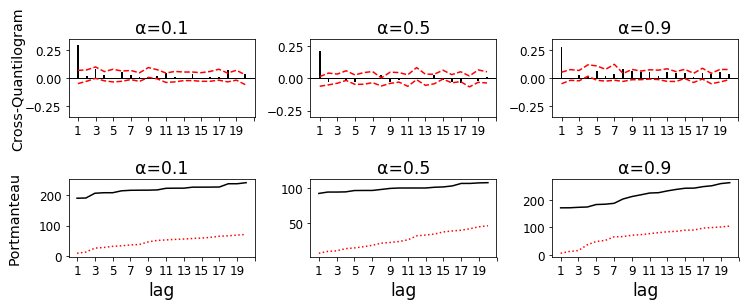

time cost: 48.51173758506775s


In [14]:
t1=time.time()
cq.bar_example(d1["day"],d2["day"])
print("time cost: {}s".format(time.time()-t1))

The figures in the first row show the CQ results at $\alpha_1=\alpha_2=\{0.1,0.5,0.5\}$ for $k \in \{1,...,20\}$. Black bars are C; Red dashed lines are 95% confidence interval generated by 1000 times stationary bootstraps.
<br>
The figures in the second row show the correspongding Portmenteau(LjungBox) Q Statistics at $\alpha_1=\alpha_2=\{0.1,0.5,0.5\}$ for $k \in \{1,...,20\}$. Black lines are Q; Red dashed lines are 95% critical value generated by 1000 times stationary bootstraps.

## 2. Heatmap plot with CQBS_alphas()

```Python
def heatmap_example(data1,data2,picname="",show=True):
    alist=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
    dataset = CQBS_alphas(data1,alist,data2,alist,1,verbose=True)
    data_mat=np.array([[d["cq"] for d in row] for row in dataset])
    data_txt=[["*" if ((d["cq"]>d["cq_upper"] or d["cq"]<d["cq_lower"])and d["q"]>d["qc"])\
                else "" for d in row] for row in dataset]
                
    fig, ax = plt.subplots(figsize=(4,5))
    im = ax.imshow(data_mat, cmap="Greys")
    ax.set_ylabel("US lag=1",fontsize="xx-large",verticalalignment="center",labelpad=5)
    ax.set_xlabel("CN",fontsize="xx-large",labelpad=35)
    cbar = ax.figure.colorbar(im,ax=ax,fraction=0.046,pad=0.02,orientation="horizontal",)
    cbar.ax.tick_params(labelsize="large")
    cbar.ax.set_ylabel("", rotation=-90, va="bottom")
    ax.set_xticks(np.arange(data_mat.shape[1]))
    ax.set_yticks(np.arange(data_mat.shape[0]))
    ax.set_yticklabels(alist,horizontalalignment="right",fontsize="large")
    ax.set_xticklabels(alist,fontsize="large")    
    ax.tick_params(top=True, bottom=False,labeltop=True, labelbottom=False)                   
    plt.setp(ax.get_xticklabels(), rotation=-60, ha="right",rotation_mode="anchor")        
    ax.set_xticks(np.arange(data_mat.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data_mat.shape[0]+1)-.5, minor=True)
    ax.tick_params(which="minor", bottom=False, left=False)
    
    data = im.get_array()
    valfmt="{x}"
    threshold = im.norm(data.max())/2.0
    textcolors=["black", "white"]
    kw = dict(horizontalalignment="center",verticalalignment="center")              
    valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[im.norm(data[i, j]) > threshold])
            text = im.axes.text(j, i, valfmt(data_txt[i][j], None),fontsize="large",**kw)

    fig.tight_layout()
    if picname:
        fig.savefig(picname+".png",dpi=200,quality=95,bbox_inches="tight")
    if show:
        print(picname+":")
        plt.show()
```

Bootstraping CQ done      
:


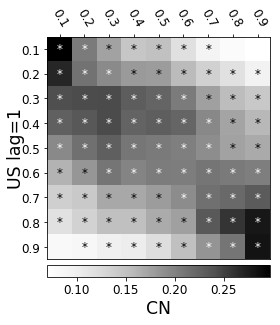

time cost: 68.4459617137909s


In [15]:
t1=time.time()
cq.heatmap_example(d1["day"],d2["day"])
print("time cost: {}s".format(time.time()-t1))

The heatmap shows the CQ at $\{(\alpha_{cn},\alpha_{us})|(\alpha_{cn},\alpha_{us})\in0.1,...,0.9\}$ and $k=1$. It represent the spillover from US market at day t towards CN market at day t+1. The star mark in each scenario means the significance in CQ and Q test.

## 3. Line(Rolling) plot with CQBS_years()

```Python
def rolling_example(data1,data2,picname="",show=True):
    alist=[0.1,0.5,0.9]
    dataset = [CQBS_years(data1,alist[i],data2,alist[i],verbose=True) for i in range(3)]
    fig1,ax1=plt.subplots(2,3,figsize=(12,6))
    plt.subplots_adjust(wspace=0.3,hspace=0.5) 
    xaxis=[x for x in dataset[0].index]
    
    ax1[0][0].set_ylabel("Rolling\nCross-Quantilogram",fontsize="x-large",labelpad=0.1)
    for i in range(3):
        ax1[0][i].set_title("α={}".format(alist[i]),fontsize="xx-large")     
        ax1[0][i].tick_params(labelsize="large")
        ax1[0][i].axhline(color="black",linewidth=1)        
        ax1[0][i].plot(xaxis,dataset[i]["cq_upper"],"rd--",markersize=5,markerfacecolor="w")
        ax1[0][i].plot(xaxis,dataset[i]["cq_lower"],"rd--",markersize=5,markerfacecolor="w")
        ax1[0][i].plot(xaxis,dataset[i]["cq"],"ko-",markersize=4)
        ax1[0][i].xaxis.set_major_locator(ticker.MultipleLocator(2))
        m = (max(abs(dataset[i]["cq"]).max(),abs(dataset[i]["cq_upper"]).max(),abs(dataset[i]["cq_lower"]).max())//0.05)*0.05+0.1
        ax1[0][i].set_ylim(-m,m)
        
    ax1[1][0].set_ylabel("Portmanteau",fontsize="x-large")
    for i in range(3):
        ax1[1][i].set_title("α={}".format(alist[i]),fontsize="xx-large")
        ax1[1][i].set_xlabel("year",fontsize="xx-large")        
        ax1[1][i].tick_params(labelsize="large")
        ax1[1][i].plot(xaxis,dataset[i]["q"],color='black')
        ax1[1][i].plot(xaxis,dataset[i]["qc"],color='red',linestyle="dotted")
        ax1[1][i].xaxis.set_major_locator(ticker.MultipleLocator(2))
    fig1.align_labels()

    if picname:
        fig1.savefig(picname+".png",dpi=200,quality=95,bbox_inches="tight")   
    if show:
        print(picname+":")
        plt.show()
```

Bootstraping CQ done      
Bootstraping CQ done      
Bootstraping CQ done      
:


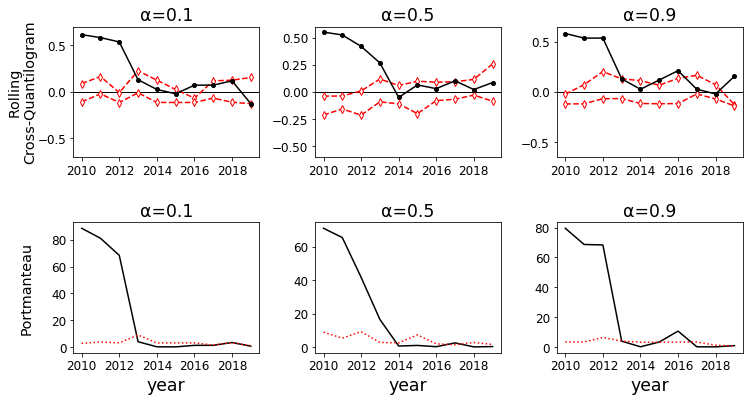

time cost: 15.774244546890259s


In [16]:
t1=time.time()
cq.rolling_example(d1["day"],d2["day"])
print("time cost: {}s".format(time.time()-t1))

The line figures show the the CQ and Portmenteau Q results at $\alpha_1=\alpha_2=\{0.1,0.5,0.5\}$ and $k=1$ for $year=\{2010,...,2019\}$